In [1]:
import os
import warnings

import pandas as pd
import seaborn as sns

from tqdm import tqdm

from jre_utils.datapath import (
    DERIVED_DATA_PATH,
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types, statistics, area_levels, period_cols

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
def transaction_period_to_date(transaction_period):
    """
    4th quarter 2020 -> (4, 2020)
    """
    split = transaction_period.split(" ")
    return int(split[0][0]), int(split[2])


def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [3]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [4]:
req_int_columns = ["Transaction-price(total)", "Area(m^2)"]

req_float_columns = ["Transaction-price(Unit price m^2)"]

req_object_columns = [
    "Prefecture",
    "City,Town,Ward,Village",
    "Type",
    "Transaction period",
]

required_columns = req_int_columns + req_float_columns + req_object_columns

float_filler = dict((col, 0) for col in req_float_columns)
int_filler = dict((col, 0) for col in req_int_columns)
object_filler = dict((col, "na") for col in req_object_columns)
na_filler = {**float_filler, **int_filler, **object_filler}

In [5]:
derived_dfs = {
    "quarterly": {
        "prefecture": {
            "land": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
            "building": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
        },
        "municipality": {
            "land": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
            "building": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
        },
    },
    "yearly": {
        "prefecture": {
            "land": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
            "building": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
        },
        "municipality": {
            "land": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
            "building": {
                "mean": pd.DataFrame(),
                "median": pd.DataFrame(),
            },
        },
    },
}

In [7]:
pbar = tqdm(total=len(trade_prices_data_paths))

for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, usecols=required_columns, encoding="unicode_escape")
    main_df = main_df.assign(Count=1)

    main_df["Municipality"] = main_df["City,Town,Ward,Village"]
    main_df["TradePrice"] = main_df["Transaction-price(total)"]
    main_df["UnitPrice"] = main_df["Transaction-price(Unit price m^2)"]
    main_df["Area"] = main_df["Area(m^2)"].apply(area_to_int)

    main_df["TradePricePerArea"] = main_df["TradePrice"] / main_df["Area"]
    main_df[["Quarter", "Year"]] = pd.DataFrame(
        main_df["Transaction period"].apply(transaction_period_to_date).values.tolist(),
        columns=["Quarter", "Year"],
    )
    main_df["Date"] = pd.PeriodIndex(
        year=main_df["Year"], quarter=main_df["Quarter"]
    ).to_timestamp()

    main_df = main_df.fillna(na_filler)
    # Zamami Village, Shimajiri County -> [Zamami Village, Shimajiri County]
    main_df[["Municipality", "SubMunicipality"]] = main_df["Municipality"].str.split(
        ",", expand=True
    )

    # Zamami Village -> Zamami
    main_df["Municipality"] = (
        main_df["Municipality"]
        .str.split(
            " ",
        )
        .apply(lambda x: x[0])
    )

    # Okinawa Prefecture -> Okinawa
    main_df["Prefecture"] = (
        main_df["Prefecture"]
        .str.split(
            " ",
        )
        .apply(lambda x: x[0])
    )

    for period, period_col in period_cols.items():
        for area_level, area_level_props in area_levels.items():
            for asset_type, asset_type_props in asset_types.items():
                for stat, statistic_dict in statistics.items():
                    df = main_df[main_df["Type"] == asset_type_props["label"]]
                    granularity_columns = area_level_props["columns"]
                    groupby_columns = granularity_columns + [period_col]
                    area_level_df = df.groupby(groupby_columns).agg(statistic_dict)

                    derived_dfs[period][area_level][asset_type][stat] = pd.concat(
                        [
                            derived_dfs[period][area_level][asset_type][stat],
                            area_level_df.reset_index(),
                        ],
                    )
    pbar.update()
pbar.close()

100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


In [20]:
# Save derived dataframes
for period, period_col in period_cols.items():
    for area_level, area_level_props in area_levels.items():
        for asset_type, asset_type_props in asset_types.items():
            for stat, statistic_dict in statistics.items():
                derived_dfs[period][area_level][asset_type][stat].to_csv(
                    get_derived_csv_path(
                        period,
                        area_level,
                        asset_type,
                        stat,
                    ),
                    index=False,
                )
                print(
                    f"Wrote to {get_derived_csv_path(period, area_level, asset_type, stat)}"
                )

Wrote to ../../data/derived/yearly_prefecture_land_mean.csv
Wrote to ../../data/derived/yearly_prefecture_land_median.csv
Wrote to ../../data/derived/yearly_prefecture_building_mean.csv
Wrote to ../../data/derived/yearly_prefecture_building_median.csv
Wrote to ../../data/derived/yearly_municipality_land_mean.csv
Wrote to ../../data/derived/yearly_municipality_land_median.csv
Wrote to ../../data/derived/yearly_municipality_building_mean.csv
Wrote to ../../data/derived/yearly_municipality_building_median.csv
Wrote to ../../data/derived/quarterly_prefecture_land_mean.csv
Wrote to ../../data/derived/quarterly_prefecture_land_median.csv
Wrote to ../../data/derived/quarterly_prefecture_building_mean.csv
Wrote to ../../data/derived/quarterly_prefecture_building_median.csv
Wrote to ../../data/derived/quarterly_municipality_land_mean.csv
Wrote to ../../data/derived/quarterly_municipality_land_median.csv
Wrote to ../../data/derived/quarterly_municipality_building_mean.csv
Wrote to ../../data/der

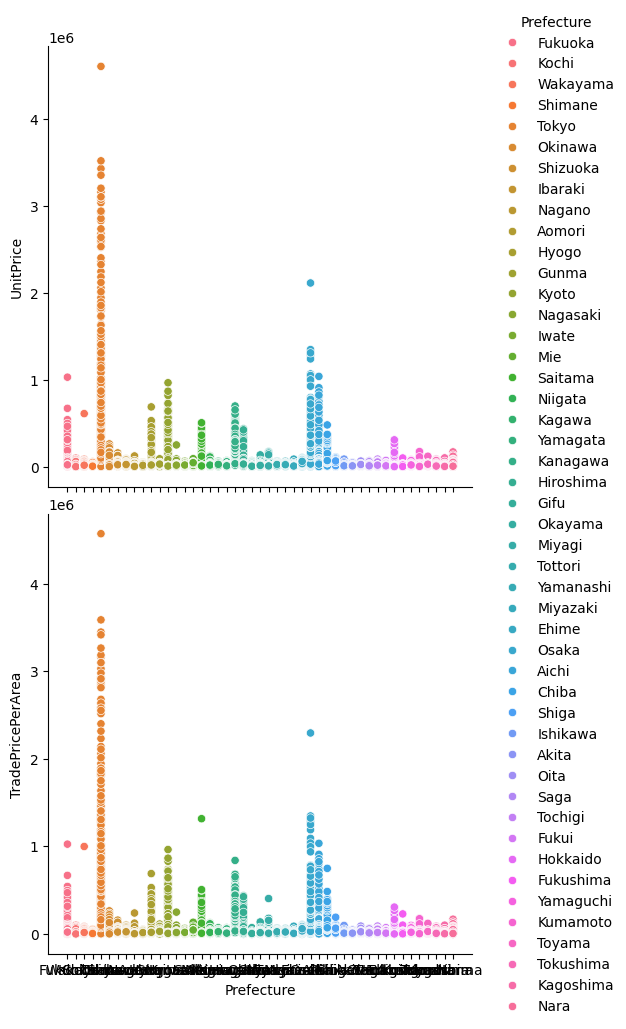

In [25]:
period = "yearly"
area_level = "municipality"
asset_type = "land"
statistic = "mean"

df = derived_dfs[period][area_level][asset_type][statistic]
_ = sns.pairplot(df, x_vars =["Prefecture"], y_vars=["UnitPrice", "TradePricePerArea"], hue="Prefecture", height = 5)

In [23]:
df

,Prefecture,Municipality,Year,TradePricePerArea,UnitPrice,Count
